In [1]:
# Numpy, JAX, Matplotlib and h5py should all be correctly installed and on the python path.
from __future__ import print_function, division, absolute_import
import datetime
import h5py
import jax.numpy as np
from jax import jacrev, random, vmap
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as onp             # original CPU-backed NumPy
import os
import sys
import time
import tensorflow as tf
from scipy import stats
from sklearn import linear_model
from numpy import linalg as LA
import numpy.random as npr
from sklearn.decomposition import PCA

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sys.path.append(os.path.join(p,'code','computation-thru-dynamics'))
import fixed_point_finder.decision as decision
import fixed_point_finder.fixed_points as fp_optimize
import fixed_point_finder.rnn as rnn
import fixed_point_finder.utils as utils

In [3]:
net = 'stepnet'
rule = 'dmcgo'
fp_epoch = 'stim1'
model_n = 0
dir_specific_all = 'crystals/softplus/l2h00001'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/
model_dir_all = os.path.join(p,'data/rnn/multitask/',dir_specific_all,str(model_n))

In [4]:
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net)

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import plot_N, plot_FP, name_best_ckpt, generate_Beta_epoch, make_h_combined, same_stim_trial, gen_X_from_model_dir_epoch

In [5]:
ckpt_n = name_best_ckpt(model_dir_all,rule)
ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

# get trial shape
_,B,N = np.shape(h_tf)
trial_set = range(0,B)

# Fixed point epoch
T = trial.epochs[fp_epoch][1]

# Input during fixed point epoch
x_star = trial.x[T-1,0,:]  

# Make a one parameter function of thie hidden state, useful for jacobians.
rnn_fun = lambda h : rnn_vanilla(params, h, x_star, alpha)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))

fp_candidates = np.transpose(h_tf,(1,0,2))  # was batch x time x dim
a = np.reshape(fp_candidates[range(0,10),trial.epochs['fix1'][1]-1,:], (-1, N)) # now batch * time x dim
b = np.reshape(fp_candidates[trial_set,trial.epochs[fp_epoch][0]:trial.epochs[fp_epoch][1]:2,:], (-1, N)) # now batch * time x dim
fp_candidates = np.concatenate((a, b), axis=0)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /home/laura/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000


In [6]:
if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    return np.dot(params[2].T,h)+params[3]

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

batch_affine = vmap(out_affine, in_axes=(None, 0))

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    o_t = batch_affine(params, h_t)
    return h_t, o_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

In [7]:
fp_loss_fun = fp_optimize.get_fp_loss_fun(rnn_fun)
total_fp_loss_fun = fp_optimize.get_total_fp_loss_fun(rnn_fun)

# Fixed point optimization hyperparameters
fp_num_batches = 50000       # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = .5          # initial learning rate
fp_decay_factor = 0.99999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 10000   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.001      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.000001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.000001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025   # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.

In [45]:
reload(fp_optimize)

fp_tols = [1e-7] # Used for both fp_tol and opt_stop_tol

model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp

    for rule in hparams['rule_trains'][-2:-1]:
        
        fldr = os.path.join(model_dir_all,'fps',rule)
        if not os.path.exists(fldr):
            os.makedirs(fldr)

        trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

        for fp_epoch in ['stim1']:

                # get trial shape
            _,B,N = np.shape(h_tf)
            trial_set = range(0,B,int(B/50))

            # Fixed point epoch
            T = trial.epochs[fp_epoch][1], 
            if T[0] is None:
                T = np.shape(trial.x)[0]

            for trial_ind in trial_set:
                # Input during fixed point epoch
                x_star = trial.x[T[0]-1,trial_ind,:]

                # Make a one parameter function of thie hidden state, useful for jacobians.
                rnn_fun = lambda h : rnn_vanilla(params, h, x_star, alpha)
                batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))

                fp_candidates = np.transpose(h_tf,(1,0,2))  # was batch x time x dim
                a = np.reshape(fp_candidates[range(0,10),trial.epochs['fix1'][1]-1,:], (-1, N)) # now batch * time x dim
                b = np.reshape(fp_candidates[trial_set,trial.epochs[fp_epoch][0]:trial.epochs[fp_epoch][1]:2,:], (-1, N)) # now batch * time x dim
                fp_candidates = np.concatenate((a, b), axis=0)

                all_fps = {}
                for tol_ind in range(len(fp_tols)):
                    tol = fp_tols[tol_ind]
                    fp_hps = {'num_batches' : fp_num_batches, 
                              'step_size' : fp_step_size, 
                              'decay_factor' : fp_decay_factor, 
                              'decay_steps' : fp_decay_steps, 
                              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 'adam_eps' : fp_adam_eps,
                              'noise_var' : fp_noise_var, 
                              'fp_opt_stop_tol' : 0, 
                              'fp_tol' : tol, 
                              'unique_tol' : fp_unique_tol, 
                              'outlier_tol' : fp_outlier_tol, 
                              'opt_print_every' : fp_opt_print_every}
                    fps, fp_losses, fp_idxs, fp_opt_details = \
                        fp_optimize.find_fixed_points(rnn_fun, fp_candidates, fp_hps, do_print=True)
                    if len(fp_idxs) > 0:
                        F_of_fps = batch_rnn_fun(fps)
                    else:
                        F_of_fps = onp.zeros([0,N])

                    all_fps[tol_ind] = {'fps' : fps, 'candidates' : fp_candidates[fp_idxs],
                                    'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                                    'opt_details' : fp_opt_details, 'hps' : fp_hps, 'tol' : tol, 'input': x_star}

                if len(all_fps[tol_ind]['losses'])>0:
                    onp.savez(fldr +'/'+ fp_epoch + '_' + str(int(np.log10(tol))) + '_' + str(trial_ind)+'.npz', **all_fps[tol_ind])



Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000
Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-10000 in 2.35 sec, Step size: 0.45242, Training loss 0.00000
    Batches 10001-20000 in 2.11 sec, Step size: 0.40936, Training loss 0.00000
    Batches 20001-30000 in 2.10 sec, Step size: 0.37041, Training loss 0.00000
    Batches 30001-40000 in 2.10 sec, Step size: 0.33516, Training loss 0.00000
    Batches 40001-50000 in 2.11 sec, Step size: 0.30326, Training loss 0.00000
Excluding fixed points with squared speed above tolerance 0.00000.
    Kept 658/660 fixed points with t

RuntimeError: Resource exhausted: Failed to allocate request for 105.47MiB (110592000B) on device ordinal 0

In [9]:
trial_ind

400

In [9]:
onp.savez(fldr +'/'+ fp_epoch + '_' + str(int(np.log10(tol))) + '_' + str(trial_ind)+'.npz', **all_fps[tol_ind])

In [12]:
ut = -7
s = 100
fldr = os.path.join(model_dir_all,'fps',rule)
filename = fldr +'/'+ fp_epoch + '_' +  str(ut) + '_' + str(s)+'.npz'
load_all_fps = onp.load(filename)

In [13]:
x_star = load_all_fps['input']
rnn_fun = lambda h : rnn_vanilla(params, h, x_star, alpha)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))
loss_fun = lambda h : np.mean((h - batch_rnn_fun(h))**2, axis=1)

In [14]:
def eig_decomp(fps):
    sorted_fps = fps
    jacs = fp_optimize.compute_jacobians(rnn_fun, sorted_fps)
    eig_decomps = fp_optimize.compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=True)
    
    return sorted_fps, eig_decomps

In [15]:
rule_master = rule

model = Model(model_dir_all)
with tf.Session() as sess:

    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial_master = generate_trials(rule_master, hparams, mode = 'test', batch_size = 400, noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial_master, hparams)
    h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)
        
Beta_epoch = generate_Beta_epoch(h_tf,trial_master)
X_pca = Beta_epoch['stim1']    
D = np.concatenate((np.expand_dims(X_pca[:,0],axis=1),np.expand_dims(X_pca[:,1],axis=1)),axis = 1)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000


/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/scipy/stats/stats.py:2251: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


In [16]:
x_star = load_all_fps['input']
rnn_fun = lambda h : rnn_vanilla(params, h, x_star, alpha)
sorted_fps, eig_decomps = eig_decomp(load_all_fps['fps'])
rand_step_coef = .0001

T = range(trial.epochs[fp_epoch][0],trial.epochs[fp_epoch][1]-1)
x_long = trial.x[T,s,:]
c = 'm'

for nfp in range(np.shape(load_all_fps['fps'])[0]):
    h0 = np.squeeze(load_all_fps['fps'][nfp,:])

    for bump_num in range(10):
        h = h0 + rand_step_coef*npr.randn(N)
        h_t = vanilla_run_at_fp(params, x_long, h, alpha)
        
        h_new = rnn_vanilla(params, h0, x_star, alpha)
        print('before:',np.mean((h_new - h0)**2),load_all_fps['losses'][nfp])

        X_trial = onp.dot(h_t,D)
        plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1)
        plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = 1)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = 1)

    X_trial = onp.dot(h0.T,D)
    plt.plot(X_trial[0],X_trial[1],'o',c = c, linewidth = 2)
    plt.plot(X_trial[0],X_trial[1],'.k', linewidth = 2)
    plt.show()

    plt.plot(eig_decomps[nfp]['evals'].real,eig_decomps[nfp]['evals'].imag,'.k')
    plt.title('max eigenval : ' +str(np.max(eig_decomps[nfp]['evals'].real)))
    plt.show()


before: 7.328606e-14 7.339946e-14


KeyboardInterrupt: 

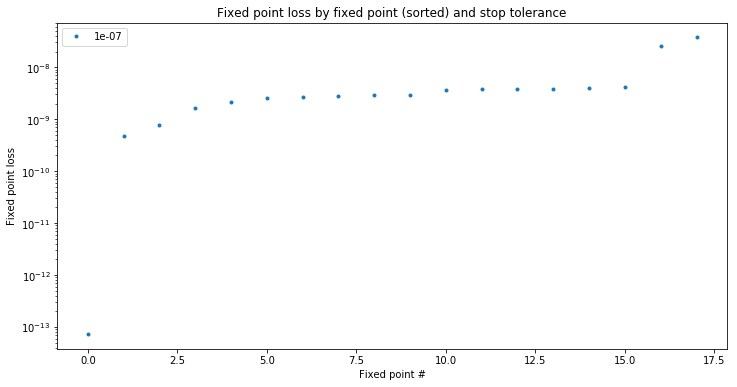

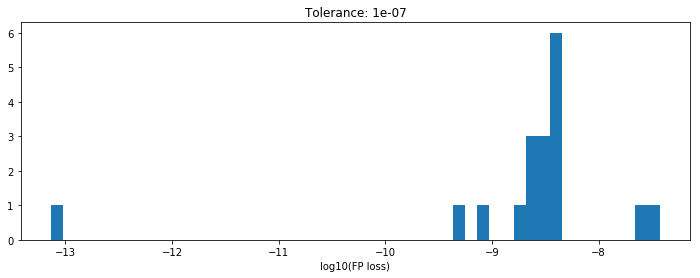

In [17]:
f1 = plt.figure(figsize=(12,6))

for tol in range(len(fp_tols)): 
    plt.semilogy(load_all_fps['losses'],'.'); 
    plt.xlabel('Fixed point #')
    plt.ylabel('Fixed point loss');
plt.legend(fp_tols)
plt.title('Fixed point loss by fixed point (sorted) and stop tolerance')

f2 = plt.figure(figsize=(12,4))

pidx = 1
nfp_tols = len(fp_tols)
nfps = onp.zeros(nfp_tols)
for tol_idx, tol in enumerate(fp_tols):
    
    nfps[tol_idx] = np.shape(load_all_fps['losses'])[0]
    plt.subplot(1, nfp_tols, pidx); pidx += 1
    plt.hist(onp.log10(fp_loss_fun(load_all_fps['fps'])), 50);
    plt.xlabel('log10(FP loss)')
    plt.title('Tolerance: ' + str(tol));

In [37]:
trial_master = generate_trials('delaygo', hparams, mode='random', batch_size = 400, noise_on=False, delay_fac =1)
trial = same_stim_trial(trial_master, 18)
X, x = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial,fp_epoch)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000


IOError: [Errno 2] No such file or directory: '/home/laura/data/rnn/multitask/crystals/softplus/l2h00001/0/fps/dmcgo/stim1_-7_80.npz'

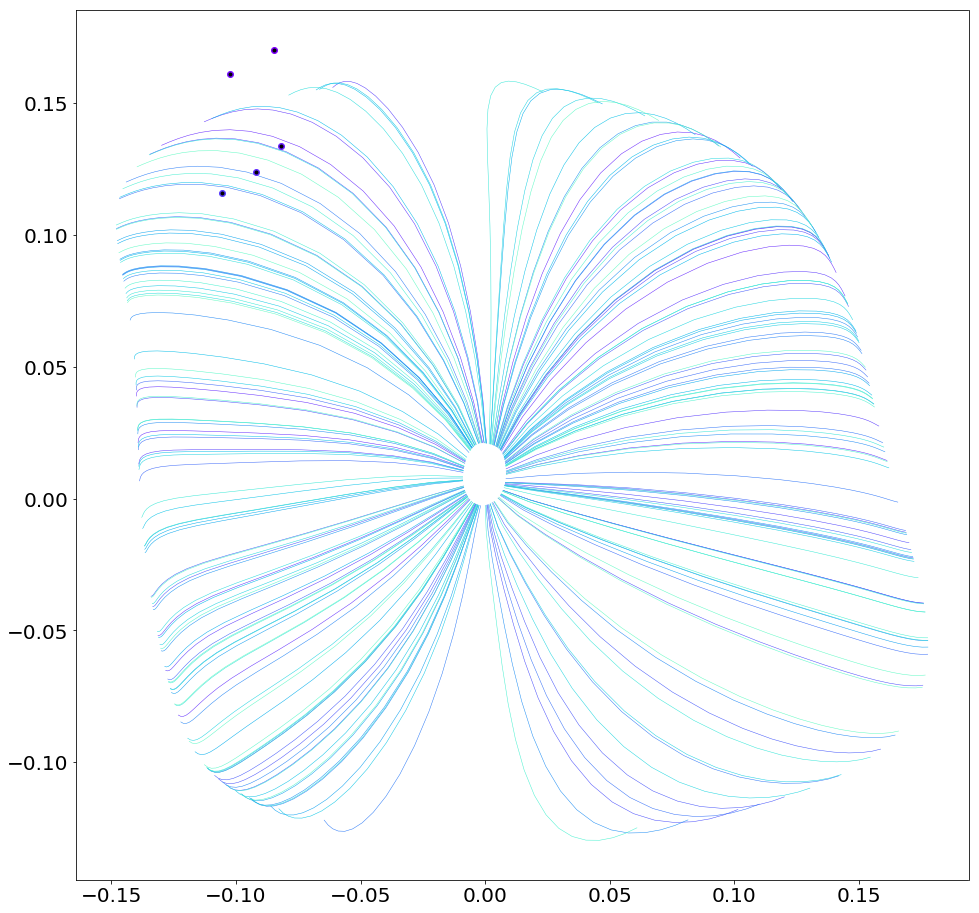

In [46]:
n=N
cmap=plt.get_cmap('rainbow')
from sklearn.decomposition import PCA
fig = plt.figure(figsize=(16,16))
trial_set = range(0,np.shape(x)[1],2)
rule = 'dmcgo'

for t_ind in range(len(trial_set)):
    hiddens = x[:,trial_set[t_ind],:].T

    h_pca = onp.dot(hiddens,D)

    a = 0.01
    plt.plot(h_pca[:,0], h_pca[:,1], color=cmap(trial.y_loc[-1,trial_set[t_ind]]/(2*np.pi)), linewidth = .5)
    
    
ut = -7
for s in range(0,800,int(800/50)):
    
    fldr = os.path.join(model_dir_all,'fps',rule)
    filename = fldr +'/'+ fp_epoch + '_' +  str(ut) + '_' + str(s)+'.npz'
    load_all_fps = onp.load(filename)
    
    for nfp in range(1):#(0,np.shape(load_all_fps['fps'])[0],2):
        h0 = np.squeeze(load_all_fps['fps'][nfp,:])
        c = cmap(s/800)

#         for bump_num in range(1):
#             print(nfp,bump_num)
#             h = h0 + rand_step_coef*npr.randn(N)
#             h_t = vanilla_run_at_fp(params, x_long, h, alpha)

#             h_new = rnn_vanilla(params, h0, x_star, alpha)

#             X_trial = onp.dot(h_t,D)
#             plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1)
#             plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = 1)
#             plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = 1)

        X_trial = onp.dot(h0.T,D)
        plt.plot(X_trial[0],X_trial[1],'o',c = c, linewidth = 2)
        plt.plot(X_trial[0],X_trial[1],'.k', linewidth = 2)

#     hstar_pca = onp.dot(sorted_fps,D)
#     marker_style = dict(marker='*', s=10, edgecolor='gray')
    
#     plt.scatter(hstar_pca[:,0], hstar_pca[:,1],c = 'k', **marker_style);#c=color[0:emax], **marker_style);
        
plt.title('Fixed point structure and fixed point candidate starting points.');
plt.xlabel(rule + ' Beta_' + fp_epoch + ' cos@')
plt.ylabel(rule + ' Beta_' + fp_epoch + ' sin@')
plt.show()

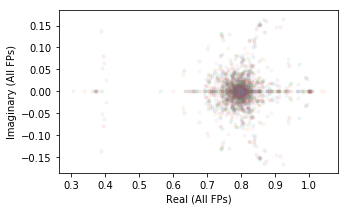

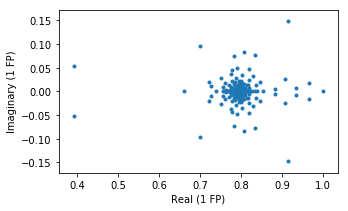

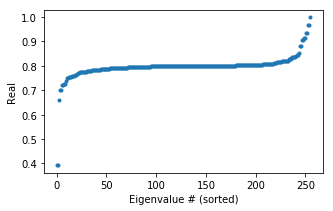

In [22]:
plt.figure(figsize=(5, 3))

for decomp in eig_decomps:
    plt.scatter(decomp['evals'].real, decomp['evals'].imag, marker = '.', alpha = 1/np.shape(fps)[0])
    
plt.ylabel('Imaginary (All FPs)')
plt.xlabel('Real (All FPs)')
plt.show()

plt.figure(figsize=(5, 3))
plt.scatter(decomp['evals'].real, decomp['evals'].imag, marker = '.')
plt.ylabel('Imaginary (1 FP)')
plt.xlabel('Real (1 FP)')
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(onp.sort(decomp['evals'].real),'.')
plt.ylabel('Real')
plt.xlabel('Eigenvalue # (sorted)')
plt.show()

In [36]:
ldots_mod1 = []
ldots_mod2 = []
rdots = []
rdotla = []  
evals = []

x = trial.x[T,0,:]
nfps = len(sorted_fps)

for jidx in range(nfps):
    fp = sorted_fps[jidx, :]
    rnn_fun_x = lambda x : rnn_vanilla(params, fp, x, alpha)
    dfdx = jacrev(rnn_fun_x)
    
    for idx in onp.argwhere(eig_decomps[jidx]['evals']>.98):
        ii = idx[0]
        r0 = onp.real(eig_decomps[jidx]['R'][:, ii])                          
        rdots.append(onp.dot(r0, params[2][:,2]))
        l0 = onp.real(eig_decomps[jidx]['L'][:, ii])
        ldots_mod1.append(onp.dot(l0, dfdx(x)[:,2]))
        ldots_mod2.append(onp.dot(l0, dfdx(x)[:,4]))
        evals.append(eig_decomps[jidx]['evals'][ii].real)

plt.figure(figsize=(4,4))
plt.subplot(111)
plt.scatter(rdots, onp.abs(ldots_mod1), np.power(np.power(100,evals),evals), c='g', label = 'mod1', alpha = .5)
plt.scatter(rdots, onp.abs(ldots_mod2), np.power(np.power(100,evals),evals), c='k', label = 'mod2', alpha = .5)
plt.legend()
plt.title(rule)
plt.ylabel('l0 dFdh . dfdx(cos@)')
plt.xlabel('r0 dFdh . W_out(cos@)')
plt.show()

TypeError: Cannot concatenate arrays with different ranks, got 2, 1.

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1235000


NameError: name 'Beta_epoch' is not defined

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


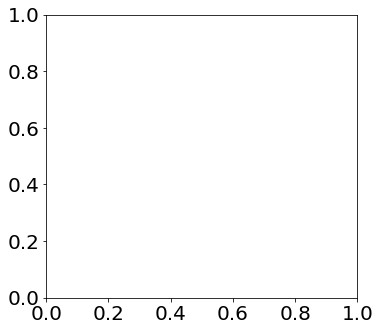

In [8]:
## plot w test set of trials
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=True, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

T_end = trial.epochs[fp_epoch][1], 
if T_end[0] is None:
    T_end = np.shape(trial.x)
    
T_start = trial.epochs[fp_epoch][0], 
if T_start[0] is None:
    T_start = (0,)
    
fig = plt.figure(figsize=(5*len(trial.epochs.keys()), 5),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 20})

e_num = 0
inds_use = range(0,np.shape(h_tf)[1],2)
h_tf_timecrop = h_tf[range(T_start[0],T_end[0]),:,:]
X = onp.transpose(h_tf_timecrop[:,inds_use,:],(1, 0, 2))
for epoch in trial.epochs.keys():
    e_num +=1
    plt.subplot(1,len(trial.epochs.keys()),e_num)
    D = np.concatenate((np.expand_dims(Beta_epoch[epoch][:,0],axis=1),np.expand_dims(Beta_epoch[epoch][:,1],axis=1)),axis = 1)
    plot_N(X,D.T,inds_use)
    plot_FP(sorted_fps, D.T, fp_losses, eig_decomps)

    plt.xlabel('Beta_' + epoch + ' cos@')
    plt.ylabel('Beta_' + epoch + ' sin@') 
    plt.title(fp_epoch+' Activity')
    plt.axis('equal')
    
plt.show()


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/no_reg/0/ckpts/model.ckpt-389000


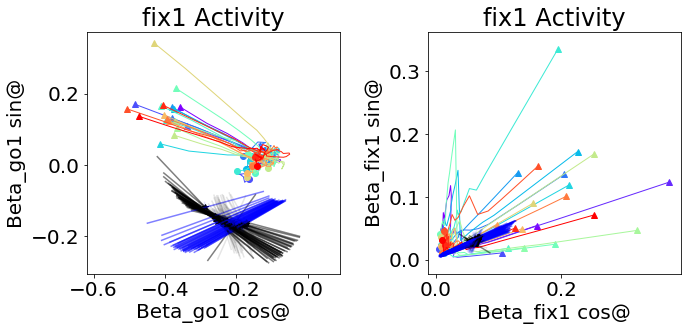

In [57]:
anti_rule = 'reactgo'

T_end = trial.epochs[fp_epoch][1], 
if T_end[0] is None:
    T_end = np.shape(trial.x)
    
T_start = trial.epochs[fp_epoch][0], 
if T_start[0] is None:
    T_start = (0,)

## plot w test set of trials
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    hparams = model.hp
    trial = generate_trials(anti_rule, hparams, mode='test', noise_on=True, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

fig = plt.figure(figsize=(5*len(trial.epochs.keys()), 5),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 20})

e_num = 0
inds_use = range(0,np.shape(h_tf)[1],2)
h_tf_timecrop = h_tf[range(T_start[0],T_end[0]),:,:]
X = onp.transpose(h_tf_timecrop[:,inds_use,:],(1, 0, 2))
for epoch in trial.epochs.keys():
    e_num +=1
    plt.subplot(1,len(trial.epochs.keys()),e_num)
    D = np.concatenate((np.expand_dims(Beta_epoch[epoch][:,0],axis=1),np.expand_dims(Beta_epoch[epoch][:,1],axis=1)),axis = 1)
    plot_N(X,D.T,inds_use)
    plot_FP(sorted_fps, D.T, fp_losses, eig_decomps)

    plt.xlabel('Beta_' + epoch + ' cos@')
    plt.ylabel('Beta_' + epoch + ' sin@') 
    plt.title(fp_epoch+' Activity')
    plt.axis('equal')
    
plt.show()


In [24]:
print(rule)

dmcgo


In [25]:
h_context_combined = []
tasks = [3,5]#range(6)#onp.concatenate(([0,2,3,5],range(11,20)))
epoch = 'stim1'

model = Model(model_dir_all)
with tf.Session() as sess:

#     rule = 'delaygo'
    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp

    for r in range(len(tasks)):
        r_all_tasks_ind = tasks[r]

        trial = generate_trials(rules_dict['all'][r_all_tasks_ind], hparams, mode = 'random', batch_size = 100, noise_on=False, delay_fac =1)

        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)
        h_context = h_tf[trial.epochs[epoch][1],:,:] # h @ end of context period

        #concatenate activity states across tasks
        if np.shape(h_context_combined)[0] == 0:
            h_context_combined = h_context
        else:
            h_context_combined = onp.concatenate((h_context_combined, h_context), axis=0)
            
pca = PCA()
X_pca = pca.fit_transform(np.squeeze(h_context_combined).T)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000


In [26]:
np.shape(trial.x)[0]

108

In [27]:
[i for i,x in enumerate(trial.stim_strength[:,0]) if .99<x<100]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [28]:
model = Model(model_dir_all)
with tf.Session() as sess:

#     rule = 'fdanti'
    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode = 'test', batch_size = 400, noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)
        
Beta_epoch = generate_Beta_epoch(h_tf,trial)
X_pca = Beta_epoch['stim1']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000


In [29]:
def plot_FP_stars(X, D, qvals, eig_decomps, cr):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    log_qvals = np.log10(qvals)

    qmap=plt.get_cmap('gray')
    S = np.shape(X)[0]
    lf = .01
    rf = .05
    
    for s in range(S):
        c = 'k'
        X_trial = np.dot(X[s,:],D.T)
        plt.plot(X_trial[0],X_trial[1],'*',c = 'k', markersize = 20)
        
        n_arg = np.max(onp.argwhere(eig_decomps[s]['evals']>1))+1
        arg = range(n_arg)
        if len(arg)>0:
            rdots = np.dot(onp.real(eig_decomps[s]['R'][:, arg]).T,D.T)
            ldots = np.dot(onp.real(eig_decomps[s]['L'][:, arg]).T,D.T)

            l = np.concatenate((X_trial - lf*ldots, X_trial + lf*ldots),0)
            plt.plot(l[0:2*n_arg:2],l[1:2*n_arg:2],'m',alpha = .5)
            r = np.concatenate((X_trial - rf*rdots, X_trial + rf*rdots),0)
            plt.plot(r[0:2*n_arg:2],r[1:2*n_arg:2],'k',alpha = .5)
        
        n_arg = eig_decomps[s]['evals']<.3
        arg = onp.argwhere(n_arg)
        if len(arg)>0:
            rdots = np.dot(onp.real(eig_decomps[s]['R'][:, arg]).T,D.T)
            ldots = np.dot(onp.real(eig_decomps[s]['L'][:, arg]).T,D.T)

            l = np.concatenate((X_trial - lf*ldots, X_trial + lf*ldots),0)
            plt.plot(l[0:2*n_arg:2],l[1:2*n_arg:2],'g',alpha = .5)
            r = np.concatenate((X_trial - rf*rdots, X_trial + rf*rdots),0)
            plt.plot(r[0:2*n_arg:2],r[1:2*n_arg:2],'b',alpha = .5)
            
        plt.plot(X_trial[0],X_trial[1],'.',c = cr, markersize = 20)

In [30]:
np.shape(rdots)

NameError: name 'rdots' is not defined

In [31]:
def plot_FP(X, D, qvals, eig_decomps, cr):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    log_qvals = np.log10(qvals)

    qmap=plt.get_cmap('gray')
    S = np.shape(X)[0]
    lf = .01
    rf = .05
    
    for s in range(S):
        c = 'k'
        
        X_trial = np.dot(X[s,:],D.T)
        
        n_arg = np.max(onp.argwhere(eig_decomps[s]['evals']>1))+1
        for arg in range(n_arg):
            rdots = np.dot(onp.real(eig_decomps[s]['R'][:, arg]).T,D.T)
            ldots = np.dot(onp.real(eig_decomps[s]['L'][:, arg]).T,D.T)
            overlap = np.dot(rdots,ldots.T)
            r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
            plt.plot(r[0:4:2],r[1:4:2],'k',alpha = .5)
        
        n_arg = np.min(onp.argwhere(eig_decomps[s]['evals']<.3))
        for arg in range(n_arg,len(eig_decomps[s]['evals'])):
            rdots = np.dot(onp.real(eig_decomps[s]['R'][:, arg]).T,D.T)
            ldots = np.dot(onp.real(eig_decomps[s]['L'][:, arg]).T,D.T)
            overlap = np.dot(rdots,ldots.T)
            r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
            plt.plot(r[0:4:2],r[1:4:2],'b',alpha = .5)
            
        plt.plot(X_trial[0],X_trial[1],'o',c = cr, markersize = 8)
        plt.plot(X_trial[0],X_trial[1],'.',c = 'k', markersize = 10)

In [32]:
np.shape(r_plus)

NameError: name 'r_plus' is not defined

In [33]:
X_trial = np.dot(sorted_fps[s,:],D)
# plt.plot(X_trial[0],X_trial[1],'.',c = 'k', markersize = 20)
n_arg = np.max(onp.argwhere(eig_decomps[s]['evals']>1))+1
arg = 0
rdots = np.dot(onp.real(eig_decomps[s]['R'][:, arg]).T,D)
ldots = np.dot(onp.real(eig_decomps[s]['L'][:, arg]).T,D)
overlap = np.dot(rdots,ldots.T)
r = np.concatenate((X_trial - overlap*rdots, X_trial + overlap*rdots),0)
plt.plot(r[0:4:2],r[1:4:2],'k',alpha = .5)

IndexError: index 100 is out of bounds for axis 0 with size 18

In [110]:
print(r[0:2*n_arg:2],r[1:2*n_arg:2])

[[-0.02248741 -0.05150166]] [[-0.02528708 -0.04314768]]


In [63]:
print(X_trial - ldots)

[[ 0.02336169 -1.3901516 ]
 [ 1.1093715  -0.25016284]
 [ 0.6999401   2.5600932 ]]


In [94]:
len(eig_decomps[s]['evals'])

256

In [34]:
def eig_decomp(fps):
    if np.shape(fps)[0]==1:
        sorted_fps = fps

        jacs = fp_optimize.compute_jacobians(rnn_fun, sorted_fps)
        eig_decomps = fp_optimize.compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=True)
    else:
#         fp_readouts = onp.squeeze(onp.dot(params[2].T,fps.T)+onp.expand_dims(params[3], axis=1))
#         fp_ro_sidxs = onp.argsort(fp_readouts[1,:])
#         sorted_fp_readouts = fp_readouts[1,fp_ro_sidxs]
        sorted_fps = fps#[fp_ro_sidxs]

        jacs = fp_optimize.compute_jacobians(rnn_fun, sorted_fps)
        eig_decomps = fp_optimize.compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=True)
    
    return sorted_fps, eig_decomps

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1208000


KeyboardInterrupt: 

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


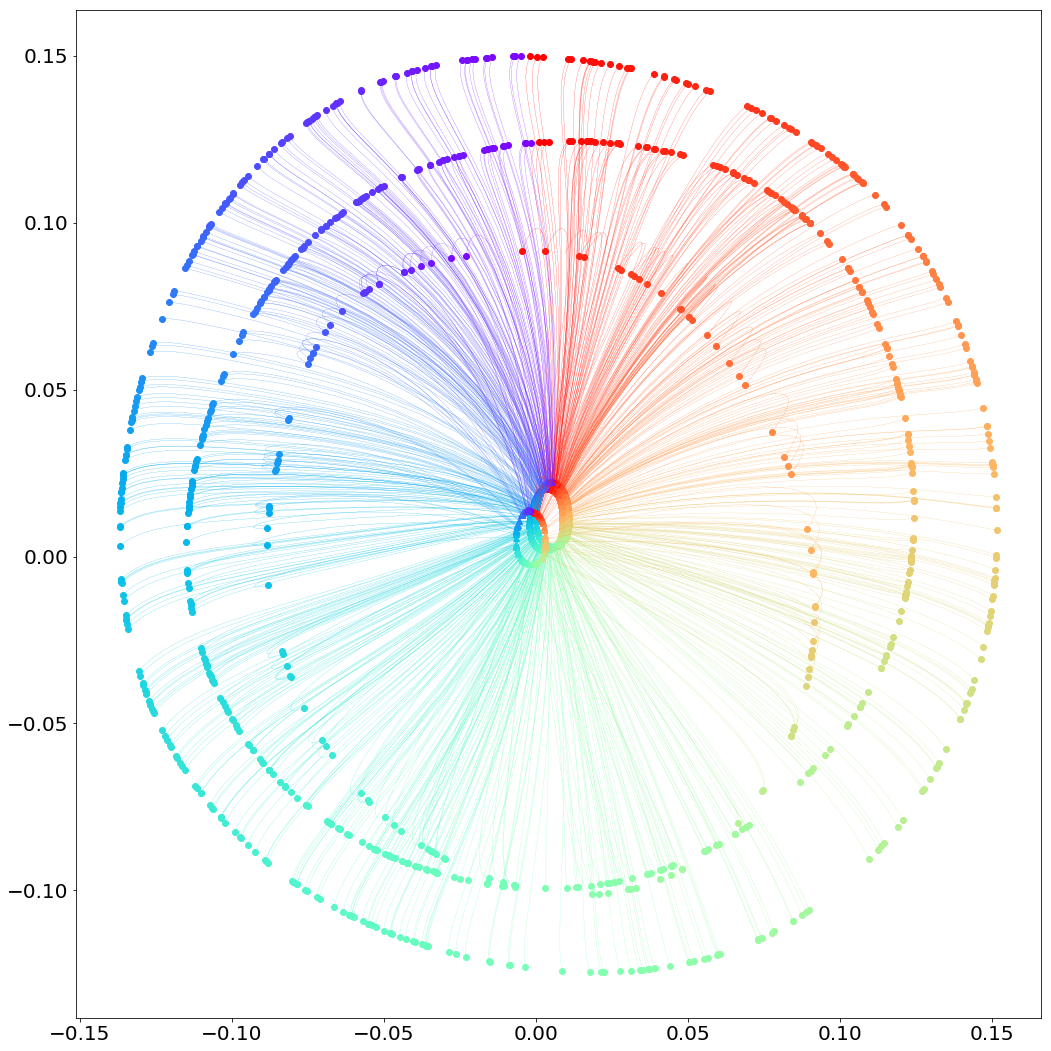

In [35]:
fp_epoch = 'stim1'
tol_ind = 0
num_trials = 400
tasks = [0,2,3,5]#range(6)#onp.concatenate(([0,2,3,5],range(11,20)))#range(6)#onp.concatenate((range(6),range(11,20)))

fig = plt.figure(figsize=(15,15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 20})

trial_master = generate_trials('delaygo', hparams, mode='random', batch_size = num_trials, noise_on=False, delay_fac =1)
    
D = np.concatenate((np.expand_dims(X_pca[:,0],axis=1),np.expand_dims(X_pca[:,1],axis=1)),axis = 1)
        
## plot w test set of trials
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    hparams = model.hp
    
    e_num = 0
    for rule_ind in tasks:
        e_num +=1
        rule = rules_dict['all'][rule_ind]
#         trial = generate_trials(rule, hparams, mode='test', batch_size = num_trials, noise_on=False, delay_fac =1)
        trial = same_stim_trial(trial_master, rule_ind)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

        T_end = trial.epochs[fp_epoch][1], 
        if T_end[0] is None:
            T_end = np.shape(trial.x)

        T_start = trial.epochs[fp_epoch][0], 
        if T_start[0] is None:
            T_start = (0,)
    
        X = onp.transpose(h_tf[range(T_start[0],T_end[0]),:,:],(1, 0, 2))
        
        cmap=plt.get_cmap('tab20')
        c = cmap(rule_ind/max(tasks))
        
        fldr = os.path.join(model_dir_all,'fps',rule)
        filename = fldr +'/'+ fp_epoch + '_' + str(tol_ind)+'.npz'
#         if os.path.exists(filename):
#             fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
        for s in range(num_trials):
        
            cmap=plt.get_cmap('rainbow')
            c = cmap(trial.y_loc[-1,s]/max(trial.y_loc[-1,:]))
            
            X_trial = np.dot(X[s,:,:],D)
            plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = .3)
            plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = .2)
            if s==0:
                plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3,label = rule)
            else:
                plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3)
            
        if os.path.exists(filename):
            load_all_fps = np.load(filename)
            sorted_fps, eig_decomps = eig_decomp(load_all_fps['fps'])
            plot_FP(sorted_fps, D.T, load_all_fps['losses'], eig_decomps,c)

plt.xlabel('Beta_' + fp_epoch + ' cos@')
plt.ylabel('Beta_' + fp_epoch + ' sin@') 
plt.title(fp_epoch+' Activity')
# plt.axis('equal')
plt.legend()        
plt.show()


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1235000


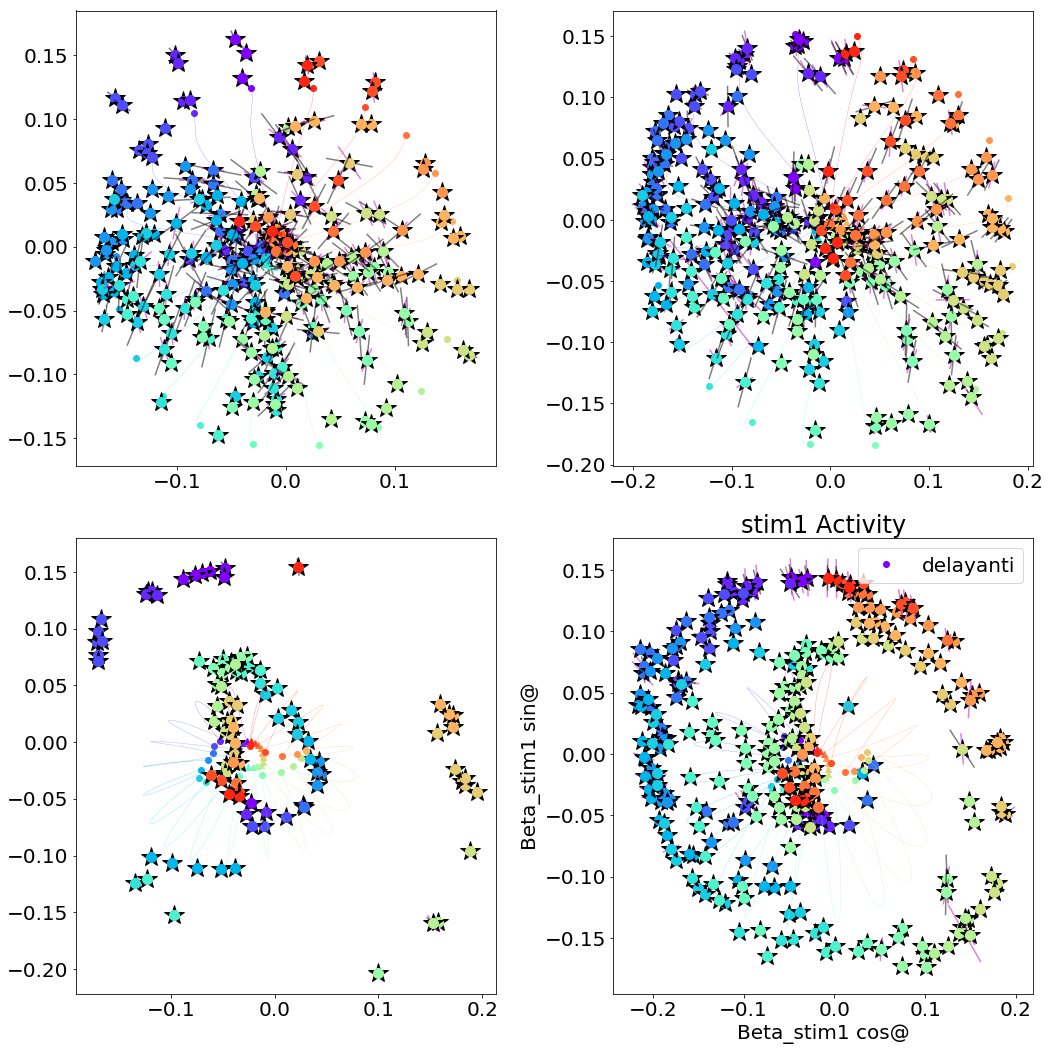

In [97]:
fp_epoch = 'stim1'
tol_ind = 0

tasks = [0,2,3,5]#range(6)#onp.concatenate(([0,2,3,5],range(11,20)))#range(6)#onp.concatenate((range(6),range(11,20)))

fig = plt.figure(figsize=(15,15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 20})
cmap=plt.get_cmap('rainbow')
trial_master = generate_trials('delaygo', hparams, mode='test', batch_size = 400, noise_on=False, delay_fac =1)
    
D = np.concatenate((np.expand_dims(X_pca[:,0],axis=1),np.expand_dims(X_pca[:,1],axis=1)),axis = 1)
        
## plot w test set of trials
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    hparams = model.hp
    
    e_num = 0
    for rule_ind in tasks:
        e_num +=1
        rule = rules_dict['all'][rule_ind]
#         trial = generate_trials(rule, hparams, mode='test', batch_size = num_trials, noise_on=False, delay_fac =1)
        trial = same_stim_trial(trial_master, rule_ind)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

        T_end = trial.epochs[fp_epoch][1], 
        if T_end[0] is None:
            T_end = np.shape(trial.x)

        T_start = trial.epochs[fp_epoch][0], 
        if T_start[0] is None:
            T_start = (0,)
    
        X = onp.transpose(h_tf[range(T_start[0],T_end[0]),:,:],(1, 0, 2))
        
        fldr = os.path.join(model_dir_all,'fps',rule)
        
        num_trials = np.shape(h_tf)[1]
        plt.subplot(2,2,e_num)
        for s in range(0,num_trials,2):
            filename = fldr +'/'+ fp_epoch + '_' +  str(-9) + '_' + str(s)+'.npz'
            c = cmap(s/num_trials)

            X_trial = np.dot(X[s,:,:],D)
            plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = .3)
            plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = .2)
            if s==0:
                plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3,label = rule)
            else:
                plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3)

            if os.path.exists(filename):
                load_all_fps = np.load(filename)
                sorted_fps, eig_decomps = eig_decomp(load_all_fps['fps'])
                plot_FP_stars(sorted_fps, D.T, load_all_fps['losses'], eig_decomps, c)

plt.xlabel('Beta_' + fp_epoch + ' cos@')
plt.ylabel('Beta_' + fp_epoch + ' sin@') 
plt.title(fp_epoch+' Activity')
# plt.axis('equal')
plt.legend()        
plt.show()


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1235000


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1235000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1235000


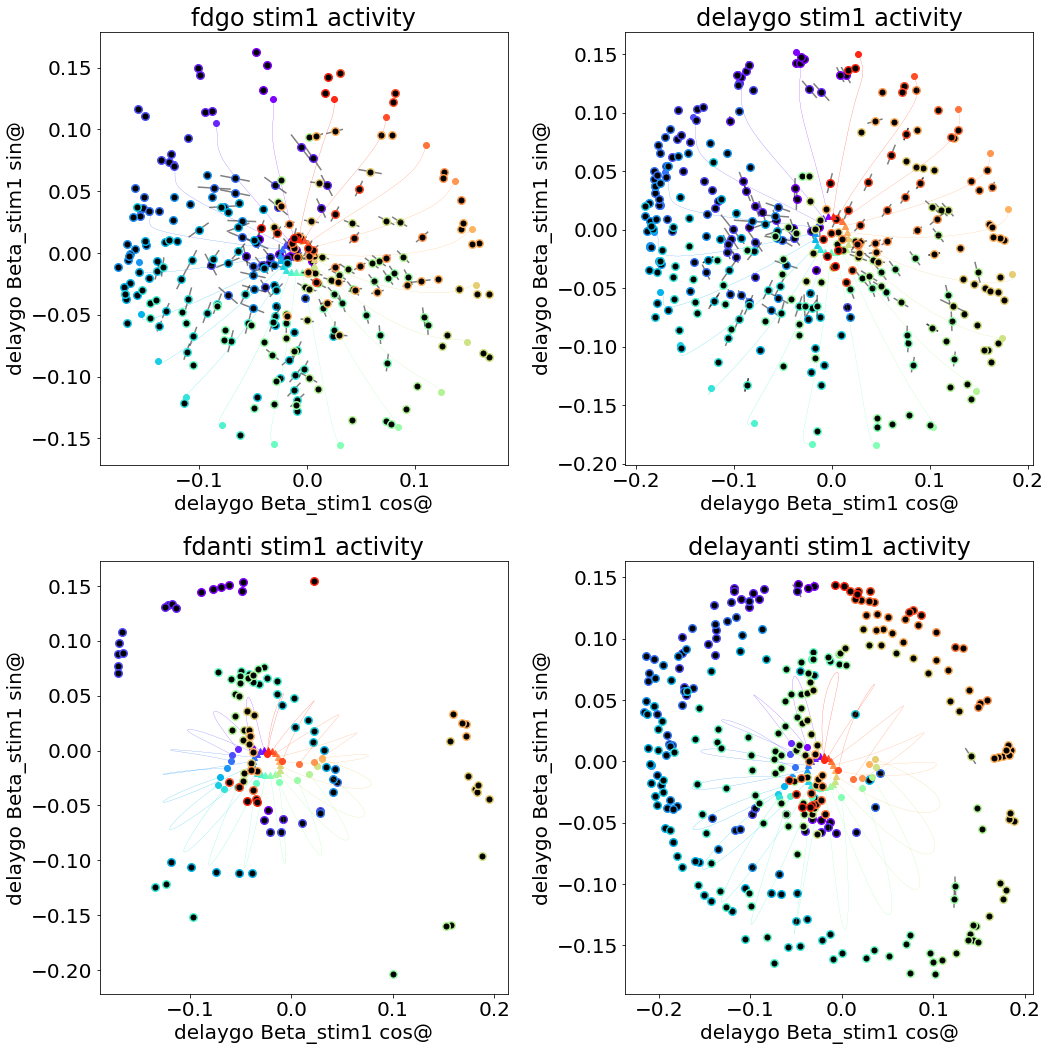

In [129]:
fp_epoch = 'stim1'
tol_ind = 0
tasks = [0,2,3,5]#range(6)#onp.concatenate(([0,2,3,5],range(11,20)))#range(6)#onp.concatenate((range(6),range(11,20)))

fig = plt.figure(figsize=(15,15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 20})
cmap=plt.get_cmap('rainbow')
rule_master = 'delaygo'

model = Model(model_dir_all)
with tf.Session() as sess:

    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial_master = generate_trials(rule_master, hparams, mode = 'test', batch_size = 400, noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial_master, hparams)
    h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)
        
Beta_epoch = generate_Beta_epoch(h_tf,trial_master)
X_pca = Beta_epoch['stim1']    
D = np.concatenate((np.expand_dims(X_pca[:,0],axis=1),np.expand_dims(X_pca[:,1],axis=1)),axis = 1)
        
## plot w test set of trials
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    hparams = model.hp
    
    e_num = 0
    for rule_ind in tasks:
        e_num +=1
        rule = rules_dict['all'][rule_ind]
#         trial = generate_trials(rule, hparams, mode='test', batch_size = num_trials, noise_on=False, delay_fac =1)
        trial = same_stim_trial(trial_master, rule_ind)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

        T_end = trial.epochs[fp_epoch][1], 
        if T_end[0] is None:
            T_end = np.shape(trial.x)

        T_start = trial.epochs[fp_epoch][0], 
        if T_start[0] is None:
            T_start = (0,)
    
        X = onp.transpose(h_tf[range(T_start[0],T_end[0]),:,:],(1, 0, 2))
        
        fldr = os.path.join(model_dir_all,'fps',rule)
        
        num_trials = np.shape(h_tf)[1]
        plt.subplot(2,2,e_num)
        for s in range(0,num_trials,2):
            filename = fldr +'/'+ fp_epoch + '_' +  str(-9) + '_' + str(s)+'.npz'
            c = cmap(s/num_trials)

            X_trial = np.dot(X[s,:,:],D)
            plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = .3)
            plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = .2)
            if s==0:
                plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3,label = rule)
            else:
                plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3)

            if os.path.exists(filename):
                load_all_fps = np.load(filename)
                sorted_fps, eig_decomps = eig_decomp(load_all_fps['fps'])
                plot_FP(sorted_fps, D.T, load_all_fps['losses'], eig_decomps, c)

        plt.xlabel(rule_master + ' Beta_' + fp_epoch + ' cos@')
        plt.ylabel(rule_master + ' Beta_' + fp_epoch + ' sin@') 
        plt.title(rule + ' '+ fp_epoch+' activity')
# plt.axis('equal')  
plt.show()


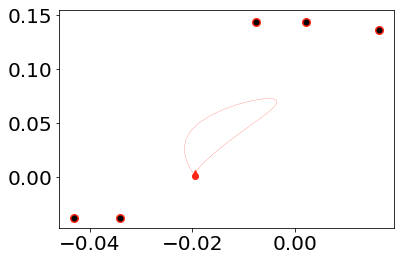

In [143]:
s = 38

filename = fldr +'/'+ fp_epoch + '_' +  str(-9) + '_' + str(s)+'.npz'
c = cmap(s/num_trials)

X_trial = np.dot(X[s,:,:],D)
plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = .3)
plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = .2)
if s==0:
    plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3,label = rule)
else:
    plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3)

if os.path.exists(filename):
    load_all_fps = np.load(filename)
    sorted_fps, eig_decomps = eig_decomp(load_all_fps['fps'])
    plot_FP(sorted_fps, D.T, load_all_fps['losses'], eig_decomps, c)

In [146]:
np.shape(sorted_fps[nfp,:])

(5, 256)

In [136]:
ckpt_n = name_best_ckpt(model_dir_all,rule)
ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

# get trial shape
_,B,N = np.shape(h_tf)
trial_set = range(0,B)

# Fixed point epoch
T = trial.epochs[fp_epoch][1]

# Input during fixed point epoch
x_star = trial.x[T-1,s,:]  

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1372000


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1372000


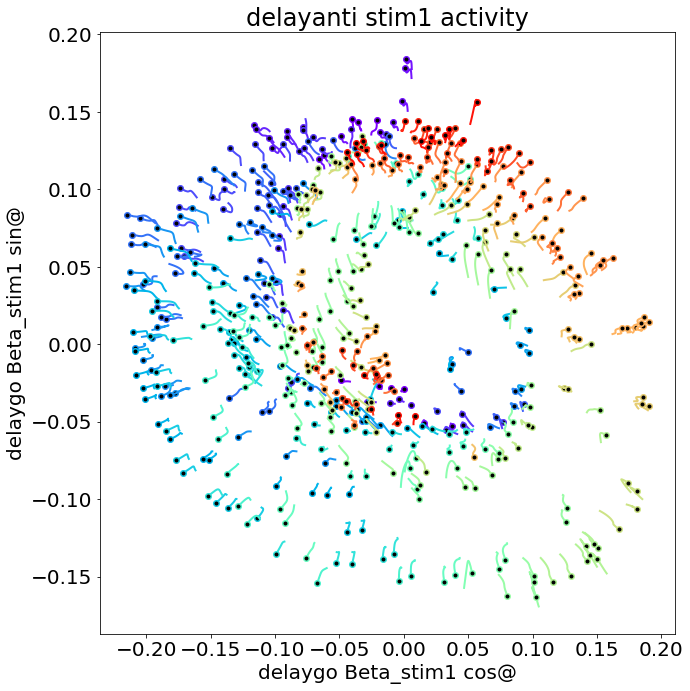

In [245]:
rule_master = 'delaygo'
rule = 'dmcgo'

model = Model(model_dir_all)
with tf.Session() as sess:

    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial_master = generate_trials(rule_master, hparams, mode = 'test', batch_size = 400, noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial_master, hparams)
    h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)
        
Beta_epoch = generate_Beta_epoch(h_tf,trial_master)
X_pca = Beta_epoch['stim1']    
D = np.concatenate((np.expand_dims(X_pca[:,0],axis=1),np.expand_dims(X_pca[:,1],axis=1)),axis = 1)
trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)


fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')

num_trials = np.shape(trial.x)[1]
T = range(trial.epochs[fp_epoch][0],trial.epochs[fp_epoch][1]-1)

for s in range(num_trials):
    filename = fldr +'/'+ fp_epoch + '_' +  str(-7) + '_' + str(s)+'.npz'
    load_all_fps = np.load(filename)
    
    x_star = trial.x[T,s,:]
    c = cmap(s/num_trials)

    for nfp in range(np.shape(load_all_fps['fps'])[0]):
        h0 = np.squeeze(load_all_fps['fps'][nfp,:])

        h_t = vanilla_run_at_fp(params, x_star, h0, alpha)

        X_trial = onp.dot(h_t,D)
        plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 2)

        X_trial = onp.dot(h0.T,D)
        plt.plot(X_trial[0],X_trial[1],'o',c = c, linewidth = 2)
        plt.plot(X_trial[0],X_trial[1],'.k', linewidth = 2)
        
plt.xlabel(rule_master + ' Beta_' + fp_epoch + ' cos@')
plt.ylabel(rule_master + ' Beta_' + fp_epoch + ' sin@') 
plt.title(rule + ' '+ fp_epoch+' activity')    
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1372000


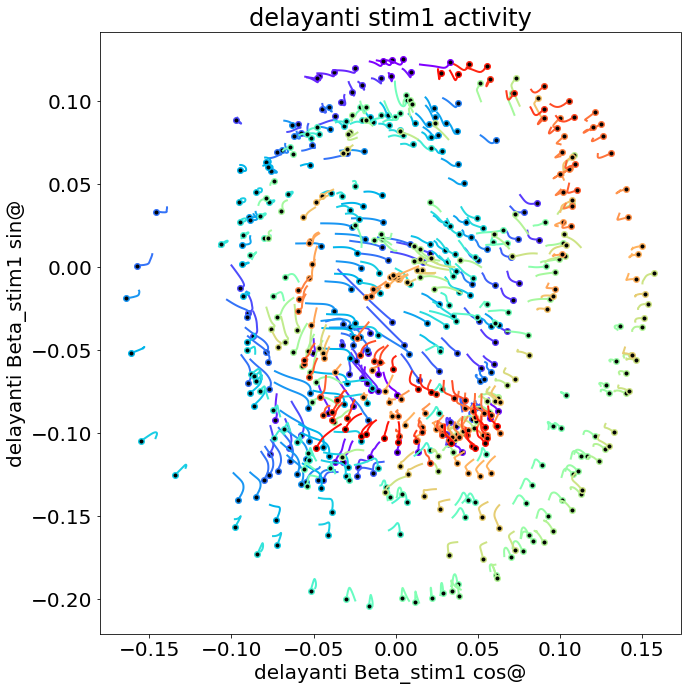

In [258]:
rule_master = 'delayanti'
rule = 'delayanti'

model = Model(model_dir_all)
with tf.Session() as sess:

    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial_master = generate_trials(rule_master, hparams, mode = 'test', batch_size = 400, noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial_master, hparams)
    h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)
        
Beta_epoch = generate_Beta_epoch(h_tf,trial_master)
X_pca = Beta_epoch['stim1']    
D = np.concatenate((np.expand_dims(X_pca[:,0],axis=1),np.expand_dims(X_pca[:,1],axis=1)),axis = 1)
trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)


fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')

num_trials = np.shape(trial.x)[1]
T = range(trial.epochs[fp_epoch][0],trial.epochs[fp_epoch][1]-1)

for s in range(num_trials):
    filename = fldr +'/'+ fp_epoch + '_' +  str(-9) + '_' + str(s)+'.npz'
    load_all_fps = np.load(filename)
    
    x_star = trial.x[T,s,:]
    c = cmap(s/num_trials)

    for nfp in range(np.shape(load_all_fps['fps'])[0]):
        h0 = np.squeeze(load_all_fps['fps'][nfp,:])

        h_t = vanilla_run_at_fp(params, x_star, h0, alpha)

        X_trial = onp.dot(h_t,D)
        plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 2)

        X_trial = onp.dot(h0.T,D)
        plt.plot(X_trial[0],X_trial[1],'o',c = c, linewidth = 2)
        plt.plot(X_trial[0],X_trial[1],'.k', linewidth = 2)
        
plt.xlabel(rule_master + ' Beta_' + fp_epoch + ' cos@')
plt.ylabel(rule_master + ' Beta_' + fp_epoch + ' sin@') 
plt.title(rule + ' '+ fp_epoch+' activity')    
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1372000


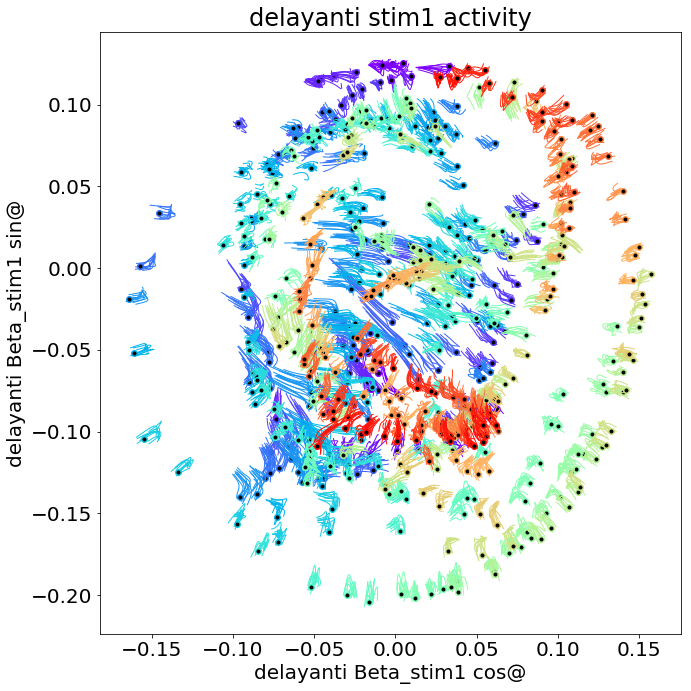

In [247]:
rule_master = 'delayanti'
rule = 'delayanti'
rand_step_coef = .002

model = Model(model_dir_all)
with tf.Session() as sess:

    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial_master = generate_trials(rule_master, hparams, mode = 'test', batch_size = 400, noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial_master, hparams)
    h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)
        
Beta_epoch = generate_Beta_epoch(h_tf,trial_master)
X_pca = Beta_epoch['stim1']    
D = np.concatenate((np.expand_dims(X_pca[:,0],axis=1),np.expand_dims(X_pca[:,1],axis=1)),axis = 1)
trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')

num_trials = np.shape(trial.x)[1]
T = range(trial.epochs[fp_epoch][0],trial.epochs[fp_epoch][1]-1)
N = np.shape(params[0])[1]

for s in range(num_trials):
    filename = fldr +'/'+ fp_epoch + '_' +  str(-9) + '_' + str(s)+'.npz'
    load_all_fps = np.load(filename)
    
    x_star = trial.x[T,s,:]
    c = cmap(s/num_trials)

    for nfp in range(np.shape(load_all_fps['fps'])[0]):
        h0 = np.squeeze(load_all_fps['fps'][nfp,:])

        for bump_num in range(10):
            h = h0 + rand_step_coef*npr.randn(N)
            h_t = vanilla_run_at_fp(params, x_star, h, alpha)

            X_trial = onp.dot(h_t,D)
            plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1)

        X_trial = onp.dot(h0.T,D)
        plt.plot(X_trial[0],X_trial[1],'o',c = c, linewidth = 2)
        plt.plot(X_trial[0],X_trial[1],'.k', linewidth = 2)
        
plt.xlabel(rule_master + ' Beta_' + fp_epoch + ' cos@')
plt.ylabel(rule_master + ' Beta_' + fp_epoch + ' sin@') 
plt.title(rule + ' '+ fp_epoch+' activity')    
plt.show()    
plt.show()

In [18]:
cmap=plt.get_cmap('tab20')

trial = generate_trials('delayanti', hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
# Input during fixed point epoch
x_star = trial.x[trial.epochs[fp_epoch][1]-1,0,:]  

# Make a one parameter function of thie hidden state, useful for jacobians.
rnn_fun = lambda h : rnn_vanilla(params, h, x_star, alpha)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))

s = 0
fp_epoch = 'stim1'

fldr = os.path.join(model_dir_all,'fps',rule)
filename = fldr +'/'+ fp_epoch + '_' +  str(-9) + '_' + str(s)+'.npz'
load_all_fps = np.load(filename)
sorted_fps, eig_decomps = eig_decomp(load_all_fps['fps'])

T = range(trial.epochs[fp_epoch][0],trial.epochs[fp_epoch][1]-1)
x_star = trial.x[T,s,:]
# c = cmap(s/num_trials)

# for nfp  in range(np.shape(load_all_fps['fps'])[0]):
#     h0 = np.squeeze(load_all_fps['fps'][nfp,:])

#     for bump_num in range(10):
#         h = h0 + rand_step_coef*npr.randn(N)
#         h_t = vanilla_run_at_fp(params, x_star, h, alpha)

#         X_trial = onp.dot(h_t,D)
#         plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1)

#     X_trial = onp.dot(h0.T,D)
#     plt.plot(X_trial[0],X_trial[1],'o',c = c, linewidth = 2)
#     plt.plot(X_trial[0],X_trial[1],'.k', linewidth = 2)
#     plt.show()

#     plt.plot(eig_decomps[nfp]['evals'].real,eig_decomps[nfp]['evals'].imag,'.k')
#     plt.title('max eigenval : ' +str(np.max(eig_decomps[nfp]['evals'].real)))
#     plt.show()



NameError: name 'cmap' is not defined

In [20]:
load_all_fps['losses']

array([1.2732172e-11, 4.1549247e-11, 5.6941434e-11, 6.6334438e-11,
       6.8659869e-11, 1.2254979e-10, 7.2090184e-10], dtype=float32)

NameError: name 'fp_tols' is not defined

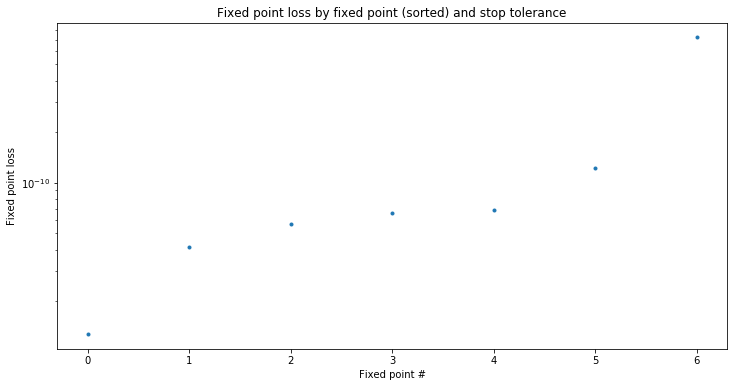

<Figure size 864x288 with 0 Axes>

In [21]:
f1 = plt.figure(figsize=(12,6))

plt.semilogy(load_all_fps['losses'],'.'); 
plt.xlabel('Fixed point #')
plt.ylabel('Fixed point loss');
plt.title('Fixed point loss by fixed point (sorted) and stop tolerance')

f2 = plt.figure(figsize=(12,4))

pidx = 1
nfp_tols = len(fp_tols)
for tol_idx, tol in enumerate(fp_tols):
    plt.subplot(1, nfp_tols, pidx); pidx += 1
    plt.hist(onp.log10(fp_loss_fun(all_fps[tol]['fps'])), 50);
    plt.xlabel('log10(FP loss)')
    plt.title('Tolerance: ' + str(tol));

In [269]:
load_all_fps['hps']

array({'opt_print_every': 100, 'adam_eps': 1e-05, 'adam_b1': 0.9, 'adam_b2': 0.999, 'unique_tol': 0.025, 'noise_var': 0.0001, 'decay_factor': 0.9999, 'decay_steps': 1, 'step_size': 0.5, 'fp_opt_stop_tol': 1e-09, 'num_batches': 10000, 'outlier_tol': 1.0, 'fp_tol': 1e-09},
      dtype=object)